In [3]:
%matplotlib inline

import sys
sys.path.append("..")

import os
import pandas as pd
import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from nilearn import datasets, plotting, input_data, signal, image  
from nilearn.input_data import NiftiLabelsMasker

from fctools import denoise

import scipy.io as scio
import numpy as np
import os 
from glob import *
import nibabel as nib
import pandas as pd
import random

H:\Jupyter\Stroke15\Multilayer_stroke15\fctools\denoise.py:14: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from nistats.design_matrix import make_first_level_design_matrix


# 1. Loading the denoising file 

In [52]:
def Select_files_by_r(rootPath, pattern, mat='mat'):
    stack_file = []
    for root,dirs,files in os.walk(rootPath):
        print(root,dirs,files)
        for file in files:
            path = root+'/'+file
            if mat == 'nii':
                nii_f = nib.load(path)
                stack_file.append(nii_f.get_fdata())
            elif mat =='mat':
#                 mat_f =  scio.loadmat(path)
                print('==> loading',path)
                stack_file.append(scio.loadmat(path))
# #     if mat == 'nii'
    return np.array(stack_file)


# top_dir = 'H:\\Matlab\\Work\\Stroke15\\Mutilayer\\Denoising\\'
top_dir = 'H:\\Matlab\\Work\\Stroke\\Conn\\stroke03\\results\\preprocessing\\' # the denoised no smooth data 
out_dir = 'H:\\Jupyter\\Stroke15\\Multilayer_stroke15\\Results\\01-extracted_timeseries\\'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
n_sub = 30
n_timepoint = 200
# denoised_files = Select_files_by_r(top_dir,'niftiDATA_Subject*_Condition000','nii')

In [33]:
# len(denoised_files)
glob(top_dir+'niftiDATA_Subject*_Condition000')

[]

Step 2: Creating parcellations 
--------------------------------

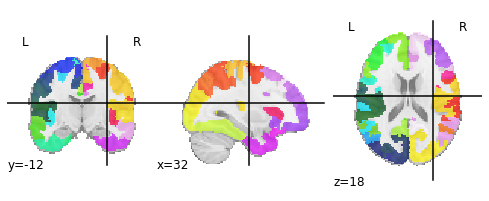

In [53]:
# Loading Power ROIs coordinates
power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file
power = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    radius = 5,
)

# Loading Schaefer atlas (300 regions)
atlas_filename = './support/Schaefer2018_300Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'
plotting.plot_roi(atlas_filename)
schaefer = input_data.NiftiLabelsMasker(atlas_filename)


parcellations = np.asarray([
#                             [network32, 'network32', 32],
                            [power, 'power', 264], 
                            [schaefer, 'schaefer', 300]])

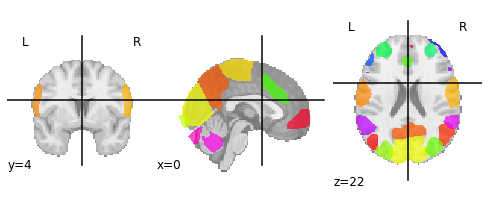

In [19]:
atlas_filename2 = 'H:\\Matlab\\Software\\conn\\rois\\networks.nii'
plotting.plot_prob_atlas(atlas_filename2,view_type = 'filled_contours')

network32 = input_data.NiftiLabelsMasker(atlas_filename2)

Step 3: Extracting timeseries
----------------------

In [49]:
import scipy.io as scio
import os

def load_conn_compound_data(compound_path,n_timepoints):
    all_compounds_array = np.zeros((n_timepoints,1))
    compound_data_mat = scio.loadmat(compound_path)
#     print(dict(compound_data ))
    compounds_data = np.squeeze(compound_data_mat['data'])
#     print(compounds_data.shape)
#     print(compounds_data)
    for i, con in enumerate(compounds_data):
        if i == 0:
            all_compounds_array = con
        else:
            all_compounds_array = np.hstack((all_compounds_array,con))
#         print(con.shape)
    return all_compounds_array

n_timepoints = 200
compound_path = 'H:\Matlab\Work\Stroke\Conn\stroke02\data\COV_Subject001_Session001.mat'
load_conn_compound_data(compound_path,n_timepoints)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  3.48215919e-03],
       [ 2.81354870e-04, -1.24118370e-03, -4.48569880e-03, ...,
         1.58278909e-02,  1.58278909e-02,  1.13451110e-01],
       [-1.99019620e-03, -1.85359700e-03,  6.88172630e-04, ...,
         1.17648330e-02,  1.17648330e-02,  4.60891248e-01],
       ...,
       [-3.94611510e-02, -2.73718850e-02, -2.27435660e-02, ...,
         1.69131812e-02,  1.69131812e-02,  1.00000000e+00],
       [-3.66682990e-02, -2.23207570e-02, -1.90982730e-02, ...,
         1.52337304e-02,  1.52337304e-02,  1.00000000e+00],
       [-3.42266980e-02, -2.50953040e-02, -2.91478750e-02, ...,
         1.88778612e-02,  1.88778612e-02,  1.00000000e+00]])

In [54]:
## for network 32 

parcellations = np.asarray([
#                             [network32, 'network32', 32],
                            [power, 'power', 264], 
                            [schaefer, 'schaefer', 300]])


top_dir2 = 'F:\\fMRI\\Stroke_fMRI\\Conn_02'
top_dir3 = 'F:\\fMRI\\Stroke_fMRI\\Conn_02'
conpound_path = 'H:\\Matlab\\Work\\Stroke\\Conn\\stroke02\\data\\'

for p in range(parcellations.shape[0]):
    n_roi = parcellations[p,2]
    
    print(f'Extracting timeseries: {parcellations[p,1]} parcellation')
    timeseries_all = np.zeros((n_sub,n_timepoint, n_roi))
    t = 0
    
    for root,dirs,files in os.walk(top_dir2):
    #     print(files)
        for match in glob(root+'/' +'wauwaunSub-*_rest_bold.nii'):
             
            #####  loading unsmooth data ####### 
            print(f'Extracting timeseries {match}')
            denoised_data = nib.load(match)
            print(denoised_data.shape)
            
            #####  loading the conn compound data ####### 
            if t+1 < 10:
                sub_name = '0'+str(t+1)
            else:sub_name = str(t+1)
            
            conpound_data_path = conpound_path + 'COV_Subject0'+sub_name+'_Session001.mat'
            conpound_data = load_conn_compound_data(conpound_data_path,n_timepoint)
            print(conpound_data_path)
            print(conpound_data.shape)
            
            #####  removing the compound and parcellated the brain with given altas ####### 
            timeseries = parcellations[p,0].fit_transform(denoised_data, confounds = conpound_data)
            timeseries = signal.clean(timeseries, 
                                            low_pass=0.09, 
                                            high_pass=0.008, 
                                            t_r = 2.0, 
                                            detrend= False, 
                                            standardize=True,
                                            )
            
            
            timeseries_all[t, :, :] = timeseries
            t = t + 1
            
        for match in glob(root+'/' +'wauwaunsub-*_task-rest_dir-AP_run-01_bold.nii'):
            print(f'Extracting timeseries {match}')
            denoised_data = nib.load(match)
            print(denoised_data.shape)
            
            #####  loading the conn compound data ####### 
            if t+1 < 10:
                sub_name = '0'+str(t+1)
            else:sub_name = str(t+1)
            
            conpound_data_path = conpound_path + 'COV_Subject0'+sub_name+'_Session001.mat'
            conpound_data = load_conn_compound_data(conpound_data_path,n_timepoint)
            print(conpound_data_path)
            print(conpound_data.shape)
            
            #####  removing the compound and parcellated the brain with given altas ####### 
            timeseries = parcellations[p,0].fit_transform(denoised_data, confounds = conpound_data)
            timeseries = signal.clean(timeseries, 
                                            low_pass=0.09, 
                                            high_pass=0.008, 
                                            t_r = 2.0, 
                                            detrend= False, 
                                            standardize=True,
                                            )
            
            timeseries_all[t, :, :] = timeseries
            t = t + 1
        
    np.save(f'{out_dir}/timeseries_{parcellations[p,1]}_no_smooth_denoised_.npy', timeseries_all)

Extracting timeseries: power parcellation
Extracting timeseries F:\fMRI\Stroke_fMRI\Conn_02\Sub-0001\func\wauwaunSub-0001_rest_bold.nii
(91, 109, 91, 200)
H:\Matlab\Work\Stroke\Conn\stroke02\data\COV_Subject001_Session001.mat
(200, 10)
Extracting timeseries F:\fMRI\Stroke_fMRI\Conn_02\Sub-0002\func\wauwaunSub-0002_rest_bold.nii
(91, 109, 91, 200)
H:\Matlab\Work\Stroke\Conn\stroke02\data\COV_Subject002_Session001.mat
(200, 12)
Extracting timeseries F:\fMRI\Stroke_fMRI\Conn_02\Sub-0003\func\wauwaunSub-0003_rest_bold.nii
(91, 109, 91, 200)
H:\Matlab\Work\Stroke\Conn\stroke02\data\COV_Subject003_Session001.mat
(200, 15)
Extracting timeseries F:\fMRI\Stroke_fMRI\Conn_02\Sub-0004\func\wauwaunSub-0004_rest_bold.nii
(91, 109, 91, 200)
H:\Matlab\Work\Stroke\Conn\stroke02\data\COV_Subject004_Session001.mat
(200, 10)
Extracting timeseries F:\fMRI\Stroke_fMRI\Conn_02\Sub-0005\func\wauwaunSub-0005_rest_bold.nii
(91, 109, 91, 200)
H:\Matlab\Work\Stroke\Conn\stroke02\data\COV_Subject005_Session001.ma

In [ ]:
print(top_dir)
path ='H:\\Matlab\\Work\\Stroke\\Conn\\stroke03\\results\\preprocessing\\niftiDATA_Subject001_Condition000.nii'
denoised_data1 = nib.load(path)

path2 ='H:\\Matlab\\Work\\Stroke\\Conn\\stroke03\\results\\preprocessing\\niftiDATA_Subject002_Condition000.nii'
denoised_data2 = nib.load(path2)

import SimpleITK as sitk

# 使用 SimpleITK 读取
n1_img2 = sitk.ReadImage(denoised_data1)

# 转为 NumPy 阵列
n1_img_arr1 = sitk.GetArrayFromImage(n1_img2)


In [14]:
# Iterating over parcellations
# for power and schearfer
for p in range(parcellations.shape[0]):
    n_roi = parcellations[p,2]
    print(f'Extracting timeseries: {parcellations[p,1]} parcellation')
    timeseries_all = np.zeros((n_sub,n_timepoint, n_roi))
        
    # Iterating over subjects, sessiosns
    t  = 0
    for i in range(n_sub):
        if i+1 <10: sub_name = '0'+str(i+1)
        else: sub_name = str(i+1)
#         print(files)
        print(sub_name)     
        data_path = top_dir+ 'niftiDATA_Subject0'+sub_name+'_Condition000.nii'
        denoised_data = nib.load(data_path)
#         print(denoised_data.shape)
# #         print(denoised_data.slicer[:,:,:,1])
        timeseries = parcellations[p,0].fit_transform(denoised_data, confounds=None)
        timeseries_all[t, :, :] = timeseries
        t = t + 1
        print(f"Sub_{t} finished")
    np.save(f'{out_dir}/{parcellations[p,1]}_no_smooth_timeseries_denoised_.npy', timeseries_all)

Extracting timeseries: power parcellation
01
Sub_1 finished
02
Sub_2 finished
03
Sub_3 finished
04
Sub_4 finished
05
Sub_5 finished
06
Sub_6 finished
07
Sub_7 finished
08
Sub_8 finished
09
Sub_9 finished
10
Sub_10 finished
11
Sub_11 finished
12
Sub_12 finished
13
Sub_13 finished
14
Sub_14 finished
15
Sub_15 finished
16
Sub_16 finished
17
Sub_17 finished
18
Sub_18 finished
19
Sub_19 finished
20
Sub_20 finished
21
Sub_21 finished
22
Sub_22 finished
23
Sub_23 finished
24
Sub_24 finished
25
Sub_25 finished
26
Sub_26 finished
27
Sub_27 finished
28
Sub_28 finished
29
Sub_29 finished
Extracting timeseries: schaefer parcellation
01
Sub_1 finished
02
Sub_2 finished
03
Sub_3 finished
04
Sub_4 finished
05
Sub_5 finished
06
Sub_6 finished
07
Sub_7 finished
08
Sub_8 finished
09
Sub_9 finished
10
Sub_10 finished
11
Sub_11 finished
12
Sub_12 finished
13
Sub_13 finished
14
Sub_14 finished
15
Sub_15 finished
16
Sub_16 finished
17
Sub_17 finished
18
Sub_18 finished
19
Sub_19 finished
20
Sub_20 finished


In [11]:
# Iterating over parcellations
# for power and schearfer
for p in range(parcellations.shape[0]):
    n_roi = parcellations[p,2]
    
    # Iterating over tasks
    
    print(f'Extracting timeseries: {parcellations[p,1]} parcellation')
    timeseries_all = np.zeros((n_sub,n_timepoint, n_roi))
        
    # Iterating over subjects, sessiosns
    t  = 0
    for root,dirs,files in os.walk(top_dir):
        print(root,dirs,files)
        for i,file in enumerate(files) :

            path = root+'\\'+file
            if not os.path.exists(path):
                print(f'{path} does not exist')
            else:
                print(f'Extracting timeseries {path}')
                denoised_data = nib.load(path)
                print(denoised_data.shape)
                timeseries = parcellations[p,0].fit_transform(denoised_data, confounds=None)
                timeseries_all[t, :, :] = timeseries
                t = t + 1
                print(f"Sub_{t} finished")
    np.save(f'{out_dir}/timeseries_{parcellations[p,1]}_denoised_.npy', timeseries_all)

Extracting timeseries: power parcellation
H:\Matlab\Work\Stroke15\Mutilayer\Denoising\ ['Subj001', 'Subj002', 'Subj003', 'Subj004', 'Subj005', 'Subj006', 'Subj007', 'Subj008', 'Subj009', 'Subj010', 'Subj011', 'Subj012', 'Subj013', 'Subj014', 'Subj015', 'Subj016', 'Subj017', 'Subj018', 'Subj019', 'Subj020', 'Subj021', 'Subj022', 'Subj023', 'Subj024', 'Subj025', 'Subj026', 'Subj027', 'Subj028', 'Subj029', 'Subj030'] []
H:\Matlab\Work\Stroke15\Mutilayer\Denoising\Subj001 [] ['niftiDATA_Subject001_Condition000.nii']
Extracting timeseries H:\Matlab\Work\Stroke15\Mutilayer\Denoising\Subj001\niftiDATA_Subject001_Condition000.nii
(91, 109, 91, 200)
Sub_1 finished
H:\Matlab\Work\Stroke15\Mutilayer\Denoising\Subj002 [] ['niftiDATA_Subject002_Condition000.nii']
Extracting timeseries H:\Matlab\Work\Stroke15\Mutilayer\Denoising\Subj002\niftiDATA_Subject002_Condition000.nii
(91, 109, 91, 200)
Sub_2 finished
H:\Matlab\Work\Stroke15\Mutilayer\Denoising\Subj003 [] ['niftiDATA_Subject003_Condition000.ni

In [10]:
timeseries_all.shape

(30, 200, 264)